<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/bert-gr-c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from pathlib import Path

# load the data
corpus_path = "data/balanced_corpus.csv"
if not Path(corpus_path).exists():
  corpus_path = 'https://raw.githubusercontent.com/ipavlopoulos/paremia/main/data/balanced_corpus.csv'
balanced_corpus = pd.read_csv(corpus_path, index_col=0)
train, test = train_test_split(balanced_corpus, test_size=0.05, random_state=2023)
train, dev = train_test_split(train, test_size=test.shape[0], random_state=2023)

In [3]:
%%capture
!pip install transformers
from transformers import BertModel, BertTokenizer
model_name = 'nlpaueb/bert-base-greek-uncased-v1'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [4]:
import torch
from sklearn.preprocessing import OneHotEncoder

# the areas that will serve as target label indices
idx2loc = {i:a for i,a in enumerate(train.area.unique())}
loc2idx = {idx2loc[i]:i for i in idx2loc}

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, max_length = 32):
        self.max_length = max_length
        self.labels = df.area.apply(lambda a: loc2idx[a])
        self.labels = np.array(self.labels.values)
        self.labels = np.reshape(self.labels, (self.labels.shape[0], 1))
        self.labels = OneHotEncoder(sparse_output=False).fit_transform(self.labels)
        self.texts = np.array(df.text.apply(lambda txt: tokenizer(txt, padding='max_length', max_length = self.max_length, truncation=True, return_tensors="pt")).values)

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        batch_texts = self.texts[idx]
        batch_labels = self.labels[idx]
        return batch_texts, batch_labels

In [5]:
from torch import nn

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.1, num_classes=1):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(768, 128, bias=True)
        self.norm = nn.BatchNorm1d(128)
        self.linear2 = nn.Linear(128, num_classes, bias=True)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        x = pooled_output
        x = self.dropout(x)
        x = self.relu(self.linear1(x))
        x = self.norm(x)
        x = self.linear2(x)
        return x

In [6]:
from torch.optim import Adam
from tqdm import tqdm

def validate(model, dataloader, device="cpu", criterion=nn.CrossEntropyLoss()):
    predictions, gold_labels = [], []
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_id, (val_input, val_label) in enumerate(dataloader):
            val_label = val_label.to(device)
            mask = val_input['attention_mask'].to(device)
            input_id = val_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            batch_loss = criterion(output, val_label)
            gold = np.argmax(val_label.cpu().detach().numpy(), axis=1)
            pred = np.argmax(output.cpu().detach().numpy(), axis=1)
            predictions.extend(pred)
            gold_labels.extend(gold)
            val_loss += batch_loss.item()
    return predictions, gold_labels, val_loss/batch_id

def finetune(model, train_data, val_data, learning_rate=2e-5, epochs=10, criterion=nn.CrossEntropyLoss(), 
             batch_size=32, max_length=32, patience=2):
    
    train_losses = []
    val_losses = []
    
    train_dataloader = torch.utils.data.DataLoader(Dataset(train_data, max_length=max_length), 
                                                   batch_size=batch_size, shuffle=True, drop_last=False)
    val_dataloader = torch.utils.data.DataLoader(Dataset(val_data, max_length=max_length), 
                                                 batch_size=batch_size, drop_last=False)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    optimizer = Adam(model.parameters(), lr=learning_rate)
    model.to(device)
    lowest_loss = 1000
    best_f1 = 0
    best_epoch = 0
    epochs_not_improving = 0
    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0
            for batch_id, (inputs, labels) in tqdm(enumerate(train_dataloader)):
                model.train()
                output = model(inputs['input_ids'].squeeze(1).to(device), 
                               inputs['attention_mask'].to(device))
                batch_loss = criterion(output.to(device), labels.to(device))
                total_loss_train += batch_loss.item()

                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()
            train_losses.append(total_loss_train/(batch_id+1))
            
            predictions, gold_labels, val_loss = validate(model, val_dataloader, device, criterion)
            f1 = f1_score(gold_labels, predictions, average='macro', zero_division=0)
            val_losses.append(val_loss)
            if f1 > best_f1:
                print(f"New best epoch found: {epoch_num} (f1: {f1:.3f})!")
                best_f1 = f1
                best_epoch = epoch_num
                torch.save(model.state_dict(), "checkpoint.pt")
                epochs_not_improving = 0
            else:
                epochs_not_improving += 1
                if epochs_not_improving >= patience:
                    model.load_state_dict(torch.load("checkpoint.pt"))
                    print('Patience is up, restoring the best model and exiting...')
                    break
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/batch_id: .3f} \
                | Val Loss: {val_loss: .3f} (best epoch: {best_epoch} w/f1: {best_f1:.3f})')
    model.eval()    
    return model, train_losses, val_losses

In [7]:
model, train_losses, val_losses = finetune(BertClassifier(num_classes=len(loc2idx)), 
                                           train, dev, 
                                           epochs=100, 
                                           patience=5, 
                                           batch_size=64, 
                                           max_length=32)

162it [00:52,  3.06it/s]


New best epoch found: 0 (f1: 0.065)!
Epochs: 1 | Train Loss:  3.229                 | Val Loss:  3.427 (best epoch: 0 w/f1: 0.065)


162it [00:55,  2.94it/s]


New best epoch found: 1 (f1: 0.131)!
Epochs: 2 | Train Loss:  2.990                 | Val Loss:  3.184 (best epoch: 1 w/f1: 0.131)


162it [00:57,  2.83it/s]


New best epoch found: 2 (f1: 0.180)!
Epochs: 3 | Train Loss:  2.790                 | Val Loss:  3.040 (best epoch: 2 w/f1: 0.180)


162it [00:57,  2.84it/s]


New best epoch found: 3 (f1: 0.180)!
Epochs: 4 | Train Loss:  2.643                 | Val Loss:  2.991 (best epoch: 3 w/f1: 0.180)


162it [00:57,  2.83it/s]


New best epoch found: 4 (f1: 0.212)!
Epochs: 5 | Train Loss:  2.521                 | Val Loss:  2.922 (best epoch: 4 w/f1: 0.212)


162it [00:57,  2.83it/s]


New best epoch found: 5 (f1: 0.213)!
Epochs: 6 | Train Loss:  2.391                 | Val Loss:  2.912 (best epoch: 5 w/f1: 0.213)


162it [00:57,  2.83it/s]


New best epoch found: 6 (f1: 0.239)!
Epochs: 7 | Train Loss:  2.243                 | Val Loss:  2.817 (best epoch: 6 w/f1: 0.239)


162it [00:57,  2.83it/s]


Epochs: 8 | Train Loss:  2.079                 | Val Loss:  2.857 (best epoch: 6 w/f1: 0.239)


162it [00:57,  2.84it/s]


New best epoch found: 8 (f1: 0.260)!
Epochs: 9 | Train Loss:  1.903                 | Val Loss:  2.845 (best epoch: 8 w/f1: 0.260)


162it [00:57,  2.83it/s]


Epochs: 10 | Train Loss:  1.696                 | Val Loss:  2.918 (best epoch: 8 w/f1: 0.260)


162it [00:57,  2.84it/s]


New best epoch found: 10 (f1: 0.267)!
Epochs: 11 | Train Loss:  1.483                 | Val Loss:  2.998 (best epoch: 10 w/f1: 0.267)


162it [00:57,  2.83it/s]


New best epoch found: 11 (f1: 0.268)!
Epochs: 12 | Train Loss:  1.259                 | Val Loss:  3.051 (best epoch: 11 w/f1: 0.268)


162it [00:57,  2.83it/s]


New best epoch found: 12 (f1: 0.272)!
Epochs: 13 | Train Loss:  1.039                 | Val Loss:  3.164 (best epoch: 12 w/f1: 0.272)


162it [00:57,  2.84it/s]


Epochs: 14 | Train Loss:  0.825                 | Val Loss:  3.278 (best epoch: 12 w/f1: 0.272)


162it [00:57,  2.83it/s]


New best epoch found: 14 (f1: 0.273)!
Epochs: 15 | Train Loss:  0.658                 | Val Loss:  3.329 (best epoch: 14 w/f1: 0.273)


162it [00:57,  2.83it/s]


Epochs: 16 | Train Loss:  0.502                 | Val Loss:  3.414 (best epoch: 14 w/f1: 0.273)


162it [00:57,  2.84it/s]


New best epoch found: 16 (f1: 0.274)!
Epochs: 17 | Train Loss:  0.386                 | Val Loss:  3.479 (best epoch: 16 w/f1: 0.274)


162it [00:57,  2.83it/s]


Epochs: 18 | Train Loss:  0.310                 | Val Loss:  3.582 (best epoch: 16 w/f1: 0.274)


162it [00:57,  2.83it/s]


New best epoch found: 18 (f1: 0.286)!
Epochs: 19 | Train Loss:  0.248                 | Val Loss:  3.647 (best epoch: 18 w/f1: 0.286)


162it [00:57,  2.83it/s]


Epochs: 20 | Train Loss:  0.196                 | Val Loss:  3.765 (best epoch: 18 w/f1: 0.286)


162it [00:57,  2.83it/s]


Epochs: 21 | Train Loss:  0.163                 | Val Loss:  3.728 (best epoch: 18 w/f1: 0.286)


162it [00:57,  2.84it/s]


Epochs: 22 | Train Loss:  0.133                 | Val Loss:  3.810 (best epoch: 18 w/f1: 0.286)


162it [00:57,  2.84it/s]


Epochs: 23 | Train Loss:  0.119                 | Val Loss:  3.842 (best epoch: 18 w/f1: 0.286)


162it [00:57,  2.84it/s]


Patience is up, restoring the best model and exiting...


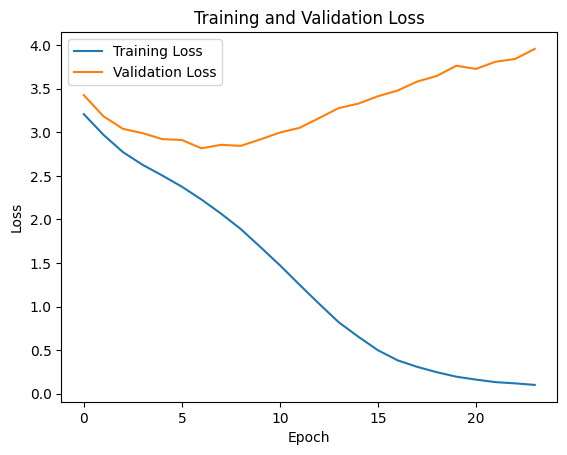

In [8]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [11]:
test_dataloader = torch.utils.data.DataLoader(Dataset(test), batch_size=1, drop_last=False)
p,l,_ = validate(model.to("cpu"), test_dataloader, "cpu")
print(classification_report([idx2loc[i] for i in l], [idx2loc[i] for i in p]))

                 precision    recall  f1-score   support

        Ήπειρος       0.05      0.04      0.04        23
        Αιτωλία       0.42      0.46      0.44        24
        Αμοργός       0.26      0.27      0.27        22
Ανατολική Θράκη       0.19      0.25      0.22        24
        Αρκαδία       0.29      0.39      0.33        31
          Αχαΐα       0.44      0.66      0.53        32
      Επτάνησος       0.43      0.39      0.41        23
         Εύβοια       0.12      0.15      0.14        20
      Θεσπρωτία       0.14      0.09      0.11        22
          Θράκη       0.16      0.16      0.16        25
       Ιωάννινα       0.16      0.14      0.15        29
       Κάρπαθος       0.33      0.18      0.23        28
     Κεφαλληνία       0.25      0.26      0.25        27
          Κρήτη       0.27      0.37      0.31        30
         Κύπρος       0.82      0.75      0.78        24
         Λέσβος       0.64      0.29      0.40        24
        Λακωνία       0.08    

In [12]:
torch.save(model.state_dict(), "bert-gr-c.pt")

In [13]:
model = BertClassifier(num_classes=len(loc2idx))
model.load_state_dict(torch.load("bert-gr-c.pt"))

<All keys matched successfully>